In [1]:
%matplotlib inline

import h5py
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl
import scipy
from collections import Counter
from ipywidgets import interact, interactive, fixed
import ipywidgets as widgets
from IPython.display import display
from numpy.random import shuffle
from scipy.spatial.distance import pdist, squareform
from scipy.spatial import KDTree

mpl.style.use('seaborn')

C:\Users\jouse\Anaconda2\envs\py36\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def get_accuracy(y_true, y_pred): 
    """
    Calculate the accuracy score.
    """
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    return np.sum(y_true == y_pred)/len(y_true)

def flat(data):
    """
    Flatten images in the data array. 
    """
    return data.reshape(data.shape[0], data.shape[1]**2)

In [3]:
# load training data and labels
with h5py.File('images_training.h5','r') as H:
    data = np.copy(H['data'])
    data = np.array([x/np.amax(x) for x in data]) # normalize images
with h5py.File('labels_training.h5','r') as H:
    label = np.copy(H['label'])

In [4]:
# load testing data and labels
with h5py.File('images_testing.h5','r') as H:
    data_test = np.copy(H['data'])
    data_test = np.array([x/np.amax(x) for x in data_test]) # normalize images
with h5py.File('labels_testing_2000.h5','r') as H:
    label_test = np.copy(H['label'])

## Singular Value Decomposition 

In [5]:
k_svd = 10 # number of singular values to save

In [6]:
# Singular Value Decomposition on training images

u, s, vh = np.linalg.svd(data)
data_svd = np.array([u[i][:,:k_svd] @ np.diag(s[i][:k_svd]) @ vh[i][:k_svd:,] for i in range(s.shape[0])])

In [7]:
# Singular Value Decomposition on testing images

u, s, vh = np.linalg.svd(data_test)
data_test_svd = np.array([u[i][:,:k_svd] @ np.diag(s[i][:k_svd]) @ vh[i][:k_svd:,] for i in range(s.shape[0])])

## Principal Component Analysis

Note: PCA is applied to the entire dataset, while SVD is applied to each image. 

In [8]:
def PCA(n_components, data):
    """
    Principal Component Analysis
    
    Parameters: 
    
    n_components: int
        Number of principal components to use
        
    data : array-like, shape = (n_samples, n_features)
        Data to perform PCA on
    
    """
    n_components = n_components
    data = data
    X = data - np.mean(data, axis=0) # data matrix normalized by mean
    S = np.cov(X.T) # compute covariance matrix of X
    L, V = np.linalg.eig(S) # L - array of eigenvalues; V - matrix of eigenvectors
    V = V[:,np.argsort(-L)][:,:n_components] # sort eigenvectors by descending order on eigenvalues
    L = -np.sort(-L)[:n_components] # sort eigenvalues by descending order
    X_PCA = V.T @ X.T
    X_PCA = X_PCA.T
    return X_PCA, V

In [9]:
n_components = 20
X_PCA, V = PCA(n_components=n_components, data=np.append(flat(data), flat(data_test), axis=0))
data_pca = X_PCA[:data.shape[0]]
data_test_pca = X_PCA[-data_test.shape[0]:]
print(data_pca.shape)
print(data_test_pca.shape)

(30000, 20)
(5000, 20)


## K-fold Cross Validation

In [10]:
def kfold(N, k=10):
    """
    Generate lists of indices for data divided into k equal parts for cross validation. 
    
    Parameters
    ----------
    N: int
        number of samples in the data. 
    
    k: int
        number of parts the data will be split into. 
    
    Returns
    -------
    indices: array, shape(k,) 
        An array of arrays, each containing the indices for one part of data. 
    """
    
    arr = np.arange(N)
    np.random.shuffle(arr)
    indices = np.array([arr[i::k] for i in range(k)])
    
    return indices

## K Nearest Neighbor Algorithm

In [11]:
class KNN:
    """
    K Nearest Neighbor
    
    Parameters
    ----------
    
    K : int. 
        Number of nearest neighbors to use for prediction
        
    """
    def __init__(self, K=5):
        self.K = K
        
    def fit_predict(self, train_data, train_label, test_data):
        """
        Fit and predict the labels for testing data

        Parameters
        ----------

        train_data : array-like, shape = (n_samples, n_features)
            Feature values in training data
        
        train_label : array-like, shape = (n_samples,)
            Target labels in training data 
            
        test_data : array-like, shape = (n_samples, n_features)
            Feature values in test data

        """
        self.train_data = train_data
        self.train_label = train_label
        self.test_data = test_data
        tree = KDTree(train_data)
        dist, indices = tree.query(test_data, k=self.K)
        y_pred = np.array([Counter(train_label[indices[n]]).most_common(1)[0][0] for n in range(test_data.shape[0])])
        return y_pred
    

### Cross Validation on PCA Transformed Data

In [12]:
# %%time

# k = 10 # number of folds for cv
# indices_cv = kfold(data_pca.shape[0], k=10) # indices for the k-folds
# score_list_PCA = []
# n_comp_list = np.arange(5, 26)
# for K in n_comp_list:
#     knn = KNN(K=K)
#     score = 0
#     for i in range(k):
#         test_id = indices_cv[i]
#         train_id = np.hstack(np.delete(indices_cv, i, 0))
#         y_true = label[test_id]
#         y_pred = knn.fit_predict(data_pca[train_id], label[train_id], data_pca[test_id])
#         score += get_accuracy(y_true, y_pred)
#     score_list_PCA.append(score/k)
# score_list_PCA = np.array(score_list_PCA)

# # Wall time: 2h 56min 10s

In [13]:
score_list_PCA = np.array([0.83923333, 0.8413    , 0.83953333, 0.84273333, 0.84116667,
                           0.84323333, 0.8412    , 0.8411    , 0.84056667, 0.84116667,
                           0.83873333, 0.83953333, 0.83746667, 0.83756667, 0.83713333,
                           0.83696667, 0.8355    , 0.8357    , 0.8348    , 0.8348    ,
                           0.8335    ])

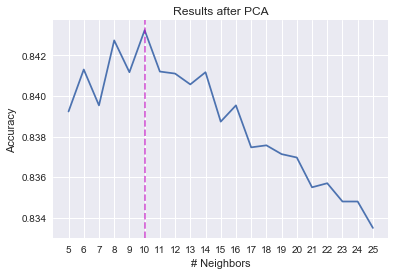

In [14]:
## CV on PCA transformed data

fig, ax = plt.subplots()
n_comp_list = np.arange(5, 26)
ax.plot(n_comp_list, score_list_PCA)
ax.axvline(n_comp_list[np.argmax(score_list_PCA)], c='m', linestyle='--', alpha=0.6)
ax.set_xlabel('# Neighbors')
ax.set_ylabel('Accuracy')
ax.set_xticks(n_comp_list)
ax.set_title('Results after PCA')
plt.show()

### Cross Validation on Original Data

In [15]:
# %%time

# k = 10 # number of folds for cv
# indices_cv = kfold(flat(data).shape[0], k=10) # indices for the k-folds
# score_list = []
# n_comp_list = np.arange(5, 26)
# for K in n_comp_list:
#     knn = KNN(K=K)
#     score = 0
#     for i in range(k):
#         test_id = indices_cv[i]
#         train_id = np.hstack(np.delete(indices_cv, i, 0))
#         y_true = label[test_id]
#         y_pred = knn.fit_predict(flat(data)[train_id], label[train_id], flat(data)[test_id])
#         score += get_accuracy(y_true, y_pred)
#     score_list.append(score/k)
# score_list = np.array(score_list)

In [16]:
score_list = np.array([0.8453    , 0.84533333, 0.84593333, 0.84646667, 0.8459    ,
                       0.8467    , 0.84503333, 0.84603333, 0.84593333, 0.84686667,
                       0.84643333, 0.84566667, 0.8455    , 0.84586667, 0.84596667,
                       0.8465    , 0.84576667, 0.8462    , 0.84563333, 0.84543333,
                       0.84443333])

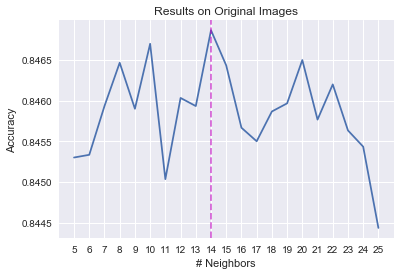

In [17]:
## CV on the original images

fig, ax = plt.subplots()
n_comp_list = np.arange(5, 26)
ax.plot(n_comp_list, score_list)
ax.axvline(n_comp_list[np.argmax(score_list)], c='m', linestyle='--', alpha=0.6)
ax.set_xlabel('# Neighbors')
ax.set_ylabel('Accuracy')
ax.set_xticks(n_comp_list)
ax.set_title('Results on Original Images')
plt.show()

## Predict on Test Data And Output

In [18]:
# %%time

# training on original images

# y_true = label_test

# knn = KNN(K=14)
# y_pred = knn.fit_predict(flat(data), label, flat(data_test))
# print(get_accuracy(y_true, y_pred[:2000]))

# # 0.8315
# # Wall time: 47min 58s

In [19]:
# %%time

# # training on svd transformed images

# y_true = label_test

# knn = KNN(K=14)
# y_pred = knn.fit_predict(flat(data_svd), label, flat(data_test_svd))
# print(get_accuracy(y_true, y_pred[:2000]))

# # 0.832
# # Wall time: 45min 45s

In [20]:
%%time

# training on pca transformed images

y_true = label_test

knn = KNN(K=10)
y_pred = knn.fit_predict(data_pca, label, data_test_pca)
print(get_accuracy(y_true, y_pred[:2000]))

# 0.8405
# Wall time: 1min 35s

0.8405
Wall time: 1min 35s


In [21]:
with h5py.File('predicted_labels.h5','w') as H:
    H.create_dataset('label',data=y_pred)